In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import fastparquet
import gc
import cPickle as pickle

In [3]:
stores_idx,items_idx,days_idx,states,cities,families,types = pickle.load(open("array_index.pkl"))

In [4]:
dim=(54, 4100, 1704)

In [5]:
def get_series(name):
    a=np.load("../input/s4/"+name+".npz")
    #print a.files
    b=a['arr_0']
    assert b.shape==dim
    return b
def get_series2(name):
    a=np.load("../input/s4/"+name+".npz")
    #print a.files
    b=a['arr_0']
    assert b.shape==(4100, 54, 1704)
    return b
def save_series(arr,name):
    assert arr.shape==dim
    print arr.dtype, arr.nbytes/1024.0**2
    np.savez_compressed("../input/s4/"+name, arr)
def save_series2(arr,name):
    print arr.dtype, arr.nbytes/1024.0**2
    np.savez_compressed("../input/s4/"+name, arr)    
def s_lag(arr,lag=1):
    l,m,n=arr.shape
    assert lag>0 and lag<n
    a=arr[:,:,:-lag]
    b=np.empty(shape=[l,m,lag],dtype=arr.dtype)
    b.fill(np.nan)
    ba=np.concatenate([b,a],axis=2)
    assert ba.shape==arr.shape
    assert ba.dtype==arr.dtype
    return ba

def forward(arr,step=1):
    l,m,n=arr.shape
    assert step>0 and step<n
    a=arr[:,:,step:]
    b=np.empty(shape=[l,m,step],dtype=arr.dtype)
    b.fill(np.nan)
    ba=np.concatenate([a,b],axis=2)
    assert ba.shape==arr.shape
    assert ba.dtype==arr.dtype
    return ba

In [6]:
def nan_equal(a,b):
    ret=( (np.abs(a - b)<1e1) | (numpy.isnan(a) & numpy.isnan(b)))
    #print np.where(~ret)
    #print a[~ret]
    #print b[~ret]
    return ret.all()
def test_mv():
    for i in range(30):
        print i,
        a=y0[i]
        df=pd.DataFrame(a.T,dtype=np.float64)
        b=pd.rolling_mean(df,window=3,min_periods=3/2+1).values
        c=y_mv3[i].T
        #print df.shape,b.shape,c.shape
        #print np.nansum(np.abs(b-c))
        assert nan_equal(b,c)        

In [7]:
def get_y(offset=0):
    assert offset>=0
    y0=get_series("y_0")
    y0[np.isnan(y0)]=0
    if offset>0:
        y0=forward(y0,step=offset)
    return y0

In [70]:
cat_lag_features={
 "city",
  "class",
  "cluster",
  "family",
  "state",
  "type",

 'city_mv36',
 'class_mv36',
 'cluster_mv36',
 'family_mv36',
 'state_mv36',
 'type_mv36',    
 
 'item_mean',
 'store_mean',
'wage',
 'nan_flag',
    'year_flag'

    
 }
cat_features={

}
sales_ma_features={'y_ma_112',
 'y_ma_14',
 'y_ma_224',
 'y_ma_28',
 'y_ma_3',
 'y_ma_56',
 'y_ma_7'}
sales_season_ma_features={'sales_week_season_ma_p13',
 'sales_week_season_ma_p2',
 'sales_week_season_ma_p3',
 'sales_week_season_ma_p4',
 'sales_week_season_ma_p7'}

In [83]:
#move x, fix y
def _get_feature(name,lag=0,offset=0):
    assert offset>0
    if name in cat_lag_features :
        assert lag == 0
        if name in ['class_mv36','family_mv36','class','family']:
            s=get_series2(name)
        else:
            s=get_series(name)
        return s_lag(s,offset)
    if name in cat_features :
        assert offset==0 and lag==0
        s= get_series(name)
        if name =='holiday': s[np.isnan(s)]=0
        return s
    if name =="y_0" or name in sales_ma_features or name in sales_season_ma_features:
        #assert  lag == 0
        s=get_series(name)
        if offset==0 and lag==0: return s
        return s_lag(s,lag=offset+lag)
def get_feature(name,lag=0,offset=0):
    s=_get_feature(name=name,lag=lag,offset=offset)
    if s.shape == ( 4100,54, 1704):
        s=np.rollaxis(s,1,0)
    assert s.shape==(54, 4100, 1704), s.shape
    return s

In [81]:
def get_all_features(offset=1):
    assert offset>0
    all_features=[]
    for name in cat_lag_features:
        all_features.append({"name":name,"lag":0,"offset":offset})
    for i in range(0,7):
        all_features.append({"name":"y_0","lag":i ,"offset":offset})  
    for name in sales_ma_features:
        all_features.append({"name":name,"lag":0,"offset":offset})  
    for name in sales_season_ma_features:
        all_features.append({"name":name,"lag":0,"offset":offset})
    return all_features    

In [73]:
def calc_feature(feat):
    return get_feature(**feat)

In [74]:
def nancorr2(a,b):
    idx=(~np.isnan(a)) & (~np.isnan(b))
    a=a[idx].flatten().astype(np.float64);b=b[idx].flatten().astype(np.float64)
    return np.corrcoef(a,b)[0,1],idx.sum()
def relation(a,b):
    idx=(~np.isnan(a)) & (~np.isnan(b))
    a=a[idx].flatten().astype(np.float64);b=b[idx].flatten().astype(np.float64)
    a=a-a.mean()
    b=b-b.mean()
    vara=(a*a).mean()
    varb=(b*b).mean()
    covab=(a*b).mean()
    return covab/np.sqrt(vara*varb),covab/varb,idx.sum()
def nancorr(y,x):
    a,b,c=relation(y,x)
    return a,b,c
def residual(y,x):
    a,b,c=relation(y,x)
    newx=x.copy()
    newx[np.isnan(newx)]=0
    return y-b*newx

In [58]:
y=get_y(0)

In [75]:
np.isnan(y).mean()

0.0

In [77]:
correlations=[]
for feat in get_all_features(1):#[::-1]:
    if feat in [u[0] for u in correlations]: continue
    print feat,
    x=    calc_feature(feat)
    r,b,c=nancorr(y,x)
    print r,b,c
    correlations.append([feat,r,b,c])

{'lag': 0, 'name': 'wage', 'offset': 1} -0.00313516512302 -0.00503397173257 377044200
{'lag': 0, 'name': 'city', 'offset': 1} 0.0736537662005 0.29828378074 367097600
{'lag': 0, 'name': 'year_flag', 'offset': 1} 0.00714895135635 0.0492667677931 377044200
{'lag': 0, 'name': 'family', 'offset': 1} 0.144481602042 0.372581485419 368270010
{'lag': 0, 'name': 'cluster_mv36', 'offset': 1} 0.0566940510536 0.288021244889 372849900
{'lag': 0, 'name': 'item_mean', 'offset': 1} 0.565929883287 0.714113613583 377044200
{'lag': 0, 'name': 'city_mv36', 'offset': 1} 0.0522112486781 0.287114600362 363981600
{'lag': 0, 'name': 'store_mean', 'offset': 1} 0.224397018099 0.495238164989 377044200
{'lag': 0, 'name': 'cluster', 'offset': 1} 0.0758288130257 0.293262259869 375949500
{'lag': 0, 'name': 'state', 'offset': 1} 0.0692778744133 0.285277461952 371808500
{'lag': 0, 'name': 'type_mv36', 'offset': 1} 0.0355611289135 0.208219153522 372911400
{'lag': 0, 'name': 'state_mv36', 'offset': 1} 0.0468492552455 0.26

In [78]:
result=pd.DataFrame(correlations,columns=['feature','corr','beta','count']).sort_values("corr",ascending=False)
result.to_csv("corr_day0.csv")
result

feature      corr      beta  \
26      {u'lag': 0, u'name': u'y_ma_7', u'offset': 1}  0.836489  0.941261   
27     {u'lag': 0, u'name': u'y_ma_14', u'offset': 1}  0.834729  0.955839   
24     {u'lag': 0, u'name': u'y_ma_28', u'offset': 1}  0.823439  0.956137   
28      {u'lag': 0, u'name': u'y_ma_3', u'offset': 1}  0.820899  0.893038   
30     {u'lag': 0, u'name': u'y_ma_56', u'offset': 1}  0.805706  0.948467   
34  {u'lag': 0, u'name': u'sales_week_season_ma_p2...  0.793394  0.857462   
29    {u'lag': 0, u'name': u'y_ma_112', u'offset': 1}  0.780789  0.933358   
35  {u'lag': 0, u'name': u'sales_week_season_ma_p3...  0.768618  0.826575   
32  {u'lag': 0, u'name': u'sales_week_season_ma_p4...  0.745673  0.795341   
25    {u'lag': 0, u'name': u'y_ma_224', u'offset': 1}  0.738880  0.902518   
31  {u'lag': 0, u'name': u'sales_week_season_ma_p7...  0.704400  0.739777   
33  {u'lag': 0, u'name': u'sales_week_season_ma_p1...  0.650725  0.679620   
17         {u'lag': 0, u'name': u'y_0', u'offset': 1}  0.580136  0.580990   
5    {u'lag': 0, u'name': u'item_mean', u'offset': 1}  0.565930  0.714114   
18         {u'lag': 1, u'name': u'y_0', u'offset': 1}  0.551041  0.552048   
19         {u'lag': 2, u'name': u'y_0', u'offset': 1}  0.535030  0.536209   
20         {u'lag': 3, u'name': u'y_0', u'offset': 1}  0.525536  0.526892   
23         {u'lag': 6, u'name': u'y_0', u'offset': 1}  0.525052  0.526485   
21         {u'lag': 4, u'name': u'y_0', u'offset': 1}  0.520354  0.521904   
22         {u'lag': 5, u'name': u'y_0', u'offset': 1}  0.519469  0.521193   
7   {u'lag': 0, u'name': u'store_mean', u'offset': 1}  0.224397  0.495238   
14       {u'lag': 0, u'name': u'class', u'offset': 1}  0.221462  0.491950   
12  {u'lag': 0, u'name': u'class_mv36', u'offset': 1}  0.205041  0.512559   
3       {u'lag': 0, u'name': u'family', u'offset': 1}  0.144482  0.372581   
15  {u'lag': 0, u'name': u'family_mv36', u'offset'...  0.127744  0.378596   
8      {u'lag': 0, u'name': u'cluster', u'offset': 1}  0.075829  0.293262   
1         {u'lag': 0, u'name': u'city', u'offset': 1}  0.073654  0.298284   
9        {u'lag': 0, u'name': u'state', u'offset': 1}  0.069278  0.285277   
13        {u'lag': 0, u'name': u'type', u'offset': 1}  0.059158  0.250358   
4   {u'lag': 0, u'name': u'cluster_mv36', u'offset...  0.056694  0.288021   
6    {u'lag': 0, u'name': u'city_mv36', u'offset': 1}  0.052211  0.287115   
11  {u'lag': 0, u'name': u'state_mv36', u'offset': 1}  0.046849  0.264402   
10   {u'lag': 0, u'name': u'type_mv36', u'offset': 1}  0.035561  0.208219   
2    {u'lag': 0, u'name': u'year_flag', u'offset': 1}  0.007149  0.049267   
0         {u'lag': 0, u'name': u'wage', u'offset': 1} -0.003135 -0.005034   
16    {u'lag': 0, u'name': u'nan_flag', u'offset': 1} -0.665881 -0.628550   

        count  
26  377044200  
27  377044200  
24  377044200  
28  377044200  
30  377044200  
34  377044200  
29  377044200  
35  377044200  
32  377044200  
25  377044200  
31  377044200  
33  377044200  
17  197820261  
5   377044200  
18  197609607  
19  197398953  
20  197188299  
23  196556337  
21  196977645  
22  196766991  
7   377044200  
14  344061540  
12  340906860  
3   368270010  
15  365152158  
8   375949500  
1   367097600  
9   371808500  
13  376011000  
4   372849900  
6   363981600  
11  368700700  
10  372911400  
2   377044200  
0   377044200  
16  377044200

In [92]:
name='y_ma_28'
s=get_series(name)

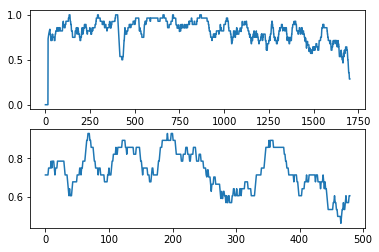

In [98]:
b=s[0,100]
f, axarr = plt.subplots(2, 1)
axarr[0].plot(b)
axarr[1].plot(b[1200:1680])

In [112]:
name='family'
s=get_series2(name)
s=np.rollaxis(s,0,2)

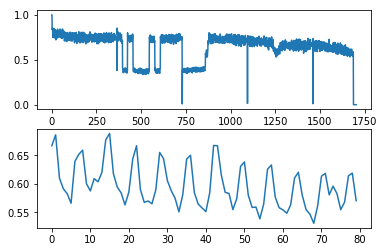

In [118]:
b=s[12,100]
f, axarr = plt.subplots(2, 1)
axarr[0].plot(b)
axarr[1].plot(b[1600:1680])

In [120]:
name='cluster_mv36'
s=get_series(name)

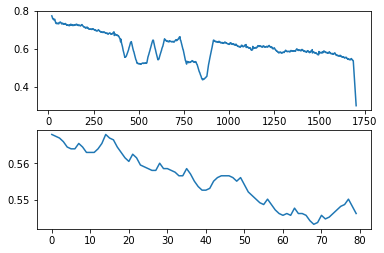

In [121]:
b=s[12,100]
f, axarr = plt.subplots(2, 1)
axarr[0].plot(b)
axarr[1].plot(b[1600:1680])

In [122]:
name='cluster'
s=get_series(name)

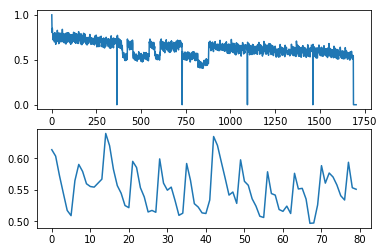

In [125]:
b=s[12,100]
f, axarr = plt.subplots(2, 1)
axarr[0].plot(b)
axarr[1].plot(b[1600:1680])

In [126]:
name='state_mv36'
s=get_series(name)

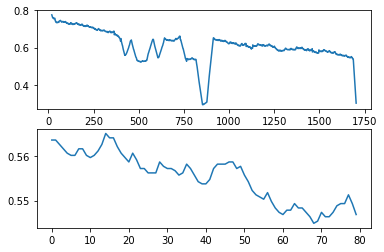

In [127]:
b=s[12,100]
f, axarr = plt.subplots(2, 1)
axarr[0].plot(b)
axarr[1].plot(b[1600:1680])

In [128]:
name='y_ma_112'
s=get_series(name)

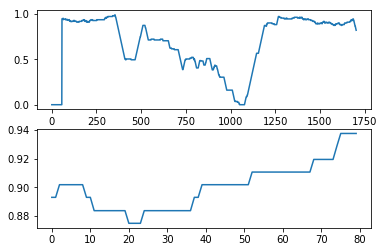

In [131]:
b=s[1,10]
f, axarr = plt.subplots(2, 1)
axarr[0].plot(b)
axarr[1].plot(b[1600:1680])

In [132]:
name='year_flag'
s=get_series(name)

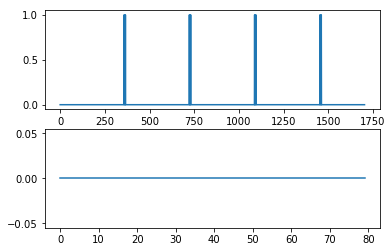

In [133]:
b=s[1,10]
f, axarr = plt.subplots(2, 1)
axarr[0].plot(b)
axarr[1].plot(b[1600:1680])

In [134]:
name='wage'
s=get_series(name)

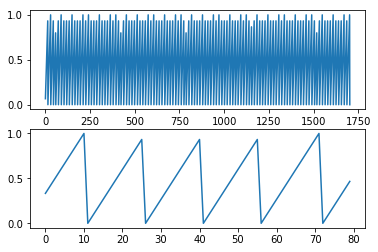

In [135]:
b=s[1,10]
f, axarr = plt.subplots(2, 1)
axarr[0].plot(b)
axarr[1].plot(b[1600:1680])

In [136]:
name='city'
s=get_series(name)

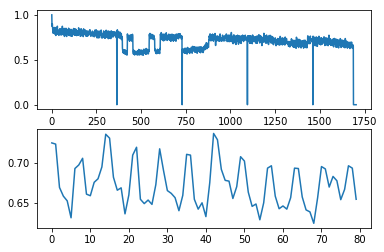

In [137]:
b=s[1,10]
f, axarr = plt.subplots(2, 1)
axarr[0].plot(b)
axarr[1].plot(b[1600:1680])

In [138]:
name='item_mean'
s=get_series(name)

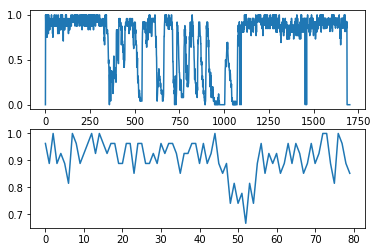

In [139]:
b=s[1,10]
f, axarr = plt.subplots(2, 1)
axarr[0].plot(b)
axarr[1].plot(b[1600:1680])

In [140]:
name='nan_flag'
s=get_series(name)

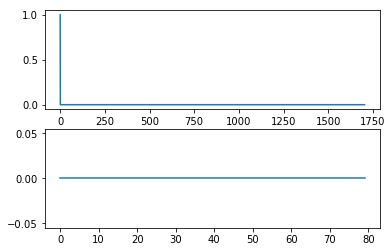

In [143]:
b=s[0,100]
f, axarr = plt.subplots(2, 1)
axarr[0].plot(b)
axarr[1].plot(b[1600:1680])

In [145]:
name='state'
s=get_series(name)

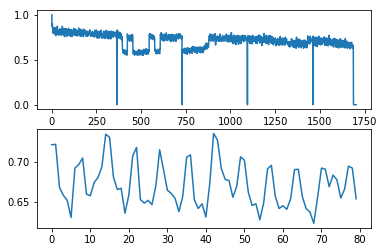

In [146]:
b=s[0,100]
f, axarr = plt.subplots(2, 1)
axarr[0].plot(b)
axarr[1].plot(b[1600:1680])

In [149]:
name='class_mv36'
s=get_series2(name)
s=np.rollaxis(s,0,2)

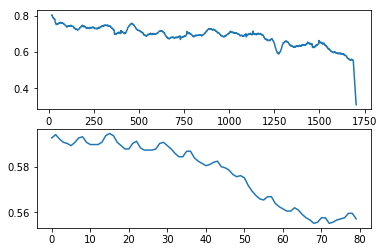

In [150]:
b=s[0,100]
f, axarr = plt.subplots(2, 1)
axarr[0].plot(b)
axarr[1].plot(b[1600:1680])

In [152]:
name='sales_week_season_ma_p7'
s=get_series(name)

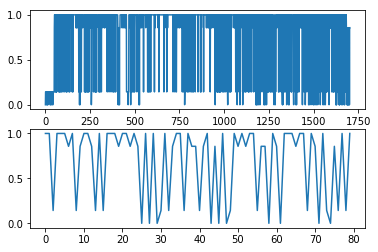

In [153]:
b=s[0,100]
f, axarr = plt.subplots(2, 1)
axarr[0].plot(b)
axarr[1].plot(b[1600:1680])

In [154]:
name='type'
s=get_series(name)

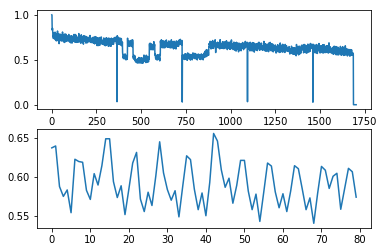

In [155]:
b=s[0,100]
f, axarr = plt.subplots(2, 1)
axarr[0].plot(b)
axarr[1].plot(b[1600:1680])

In [156]:
name='sales_week_season_ma_p3'
s=get_series(name)

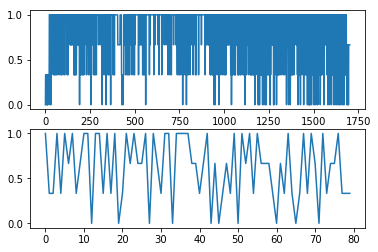

In [157]:
b=s[0,100]
f, axarr = plt.subplots(2, 1)
axarr[0].plot(b)
axarr[1].plot(b[1600:1680])

In [158]:
name='type_mv36'
s=get_series(name)

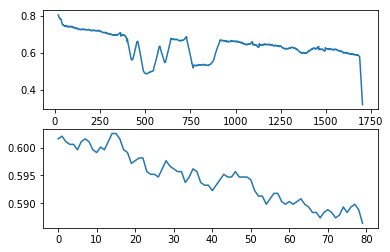

In [159]:
b=s[0,100]
f, axarr = plt.subplots(2, 1)
axarr[0].plot(b)
axarr[1].plot(b[1600:1680])

In [160]:
name='store_mean'
s=get_series(name)

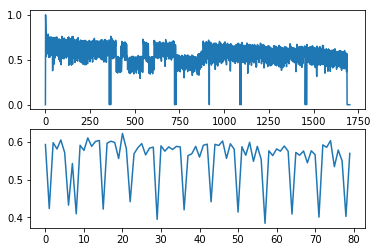

In [161]:
b=s[0,100]
f, axarr = plt.subplots(2, 1)
axarr[0].plot(b)
axarr[1].plot(b[1600:1680])

In [163]:
name='class'
s=get_series2(name)
s=np.rollaxis(s,0,2)

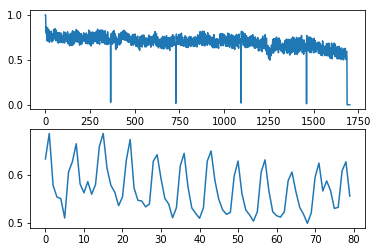

In [164]:
b=s[0,100]
f, axarr = plt.subplots(2, 1)
axarr[0].plot(b)
axarr[1].plot(b[1600:1680])

In [165]:
name='city_mv36'
s=get_series(name)

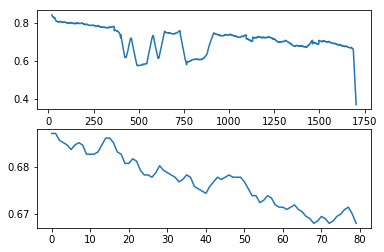

In [166]:
b=s[0,100]
f, axarr = plt.subplots(2, 1)
axarr[0].plot(b)
axarr[1].plot(b[1600:1680])

In [168]:
name='family_mv36'
s=get_series2(name)
s=np.rollaxis(s,0,2)

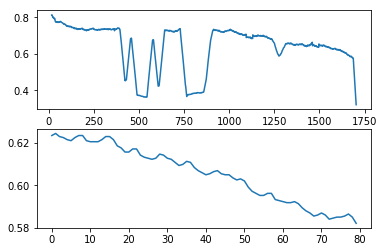

In [169]:
b=s[0,100]
f, axarr = plt.subplots(2, 1)
axarr[0].plot(b)
axarr[1].plot(b[1600:1680])

In [89]:
str(set([u[0]['name'] for u in correlations]))

"set(['y_ma_28', 'family', 'cluster_mv36', 'cluster', 'state_mv36', 'y_ma_112', 'y_0', 'year_flag', 'wage', 'city', 'y_ma_7', 'item_mean', 'y_ma_3', 'nan_flag', 'state', 'class_mv36', 'sales_week_season_ma_p7', 'sales_week_season_ma_p4', 'y_ma_56', 'type', 'sales_week_season_ma_p3', 'y_ma_14', 'sales_week_season_ma_p13', 'type_mv36', 'store_mean', 'class', 'y_ma_224', 'sales_week_season_ma_p2', 'city_mv36', 'family_mv36'])"

In [171]:
 ['y_ma_28', 'family', 'cluster_mv36', 'cluster', 'state_mv36', 'y_ma_112', 
             'y_0', 'year_flag', 'wage', 'city', 'y_ma_7', 'item_mean', 'y_ma_3', 'nan_flag',
             'state', 'class_mv36', 'sales_week_season_ma_p7', 'sales_week_season_ma_p4',
             'y_ma_56', 'type', 'sales_week_season_ma_p3', 'y_ma_14', 'sales_week_season_ma_p13',
             'type_mv36', 'store_mean', 'class', 'y_ma_224', 'sales_week_season_ma_p2', 'city_mv36', 'family_mv36']
 

['y_ma_28',
 'family',
 'cluster_mv36',
 'cluster',
 'state_mv36',
 'y_ma_112',
 'y_0',
 'year_flag',
 'wage',
 'city',
 'y_ma_7',
 'item_mean',
 'y_ma_3',
 'nan_flag',
 'state',
 'class_mv36',
 'sales_week_season_ma_p7',
 'sales_week_season_ma_p4',
 'y_ma_56',
 'type',
 'sales_week_season_ma_p3',
 'y_ma_14',
 'sales_week_season_ma_p13',
 'type_mv36',
 'store_mean',
 'class',
 'y_ma_224',
 'sales_week_season_ma_p2',
 'city_mv36',
 'family_mv36']

In [85]:
correlations=[]
for feat in get_all_features(15):#[::-1]:
    if feat in [u[0] for u in correlations]: continue
    print feat,
    x=    calc_feature(feat)
    r,b,c=nancorr(y,x)
    print r,b,c
    correlations.append([feat,r,b,c])

 {'lag': 0, 'name': 'wage', 'offset': 15} -0.00467468886764 -0.00751097016087 373944600
{'lag': 0, 'name': 'city', 'offset': 15} 0.0418657342473 0.195882257354 363998000
{'lag': 0, 'name': 'year_flag', 'offset': 15} 0.00446827069308 0.0306954261777 373944600
{'lag': 0, 'name': 'family', 'offset': 15} 0.117715422168 0.319147249499 365170410
{'lag': 0, 'name': 'cluster_mv36', 'offset': 15} 0.0437274543901 0.22646706494 369750300
{'lag': 0, 'name': 'item_mean', 'offset': 15} 0.534112320042 0.675931974955 373944600
{'lag': 0, 'name': 'city_mv36', 'offset': 15} 0.038119441446 0.21429204961 360882000
{'lag': 0, 'name': 'store_mean', 'offset': 15} 0.208446184099 0.473962410102 373944600
{'lag': 0, 'name': 'cluster', 'offset': 15} 0.047004310643 0.206890443277 372849900
{'lag': 0, 'name': 'state', 'offset': 15} 0.0371902682014 0.177745612596 368708900
{'lag': 0, 'name': 'type_mv36', 'offset': 15} 0.0220570659828 0.132573455229 369811800
{'lag': 0, 'name': 'state_mv36', 'offset': 15} 0.03250082

In [86]:
result=pd.DataFrame(correlations,columns=['feature','corr','beta','count']).sort_values("corr",ascending=False)
result.to_csv("corr_day15.csv")
result

feature      corr      beta  \
27    {u'lag': 0, u'name': u'y_ma_14', u'offset': 15}  0.791325  0.905015   
24    {u'lag': 0, u'name': u'y_ma_28', u'offset': 15}  0.789759  0.916133   
26     {u'lag': 0, u'name': u'y_ma_7', u'offset': 15}  0.786090  0.883739   
30    {u'lag': 0, u'name': u'y_ma_56', u'offset': 15}  0.784069  0.922949   
28     {u'lag': 0, u'name': u'y_ma_3', u'offset': 15}  0.763974  0.830439   
29   {u'lag': 0, u'name': u'y_ma_112', u'offset': 15}  0.762771  0.912437   
34  {u'lag': 0, u'name': u'sales_week_season_ma_p2...  0.746204  0.805192   
35  {u'lag': 0, u'name': u'sales_week_season_ma_p3...  0.733288  0.787947   
25   {u'lag': 0, u'name': u'y_ma_224', u'offset': 15}  0.727928  0.890271   
32  {u'lag': 0, u'name': u'sales_week_season_ma_p4...  0.719181  0.766926   
31  {u'lag': 0, u'name': u'sales_week_season_ma_p7...  0.686716  0.721738   
33  {u'lag': 0, u'name': u'sales_week_season_ma_p1...  0.637921  0.667226   
5   {u'lag': 0, u'name': u'item_mean', u'offset': 15}  0.534112  0.675932   
17        {u'lag': 0, u'name': u'y_0', u'offset': 15}  0.472372  0.475492   
23        {u'lag': 6, u'name': u'y_0', u'offset': 15}  0.462142  0.465464   
18        {u'lag': 1, u'name': u'y_0', u'offset': 15}  0.461933  0.465167   
19        {u'lag': 2, u'name': u'y_0', u'offset': 15}  0.456365  0.459577   
22        {u'lag': 5, u'name': u'y_0', u'offset': 15}  0.455623  0.458878   
20        {u'lag': 3, u'name': u'y_0', u'offset': 15}  0.453292  0.456493   
21        {u'lag': 4, u'name': u'y_0', u'offset': 15}  0.452628  0.455837   
7   {u'lag': 0, u'name': u'store_mean', u'offset':...  0.208446  0.473962   
14      {u'lag': 0, u'name': u'class', u'offset': 15}  0.191094  0.439970   
12  {u'lag': 0, u'name': u'class_mv36', u'offset':...  0.187408  0.469680   
3      {u'lag': 0, u'name': u'family', u'offset': 15}  0.117715  0.319147   
15  {u'lag': 0, u'name': u'family_mv36', u'offset'...  0.113632  0.338325   
8     {u'lag': 0, u'name': u'cluster', u'offset': 15}  0.047004  0.206890   
4   {u'lag': 0, u'name': u'cluster_mv36', u'offset...  0.043727  0.226467   
1        {u'lag': 0, u'name': u'city', u'offset': 15}  0.041866  0.195882   
6   {u'lag': 0, u'name': u'city_mv36', u'offset': 15}  0.038119  0.214292   
9       {u'lag': 0, u'name': u'state', u'offset': 15}  0.037190  0.177746   
11  {u'lag': 0, u'name': u'state_mv36', u'offset':...  0.032501  0.187700   
13       {u'lag': 0, u'name': u'type', u'offset': 15}  0.027238  0.135236   
10  {u'lag': 0, u'name': u'type_mv36', u'offset': 15}  0.022057  0.132573   
2   {u'lag': 0, u'name': u'year_flag', u'offset': 15}  0.004468  0.030695   
0        {u'lag': 0, u'name': u'wage', u'offset': 15} -0.004675 -0.007511   
16   {u'lag': 0, u'name': u'nan_flag', u'offset': 15} -0.660237 -0.623575   

        count  
27  373944600  
24  373944600  
26  373944600  
30  373944600  
28  373944600  
29  373944600  
34  373944600  
35  373944600  
25  373944600  
32  373944600  
31  373944600  
33  373944600  
5   373944600  
17  194871105  
23  193787467  
18  194660451  
19  194485766  
22  193961967  
20  194311125  
21  194136523  
7   373944600  
14  340975548  
12  337816116  
3   365170410  
15  362052558  
8   372849900  
4   369750300  
1   363998000  
6   360882000  
9   368708900  
11  365601100  
13  372911400  
10  369811800  
2   373944600  
0   373944600  
16  373944600

In [28]:
correlations=[]

In [ ]:
import gc
gc.collect()